In [2]:
# Author: Umut Mehmet ERDEM - 2024

import matplotlib.pyplot as plt
import numpy as np
from numpy.fft import fft 

"""
@brief Writes data data to a file in PGM format (P2 or P5).
@param1 magicnum: Magic number representing the PGM format (P2 for ASCII, P5 for binary).
@param2 filename: Path of the file to write the data data.
@param3 width: Width of the image.
@param4 height: Height of the image.
@param5 maxval: Maximum pixel value.
@param6 data: 2D list containing the data pixel data.
@retval None
"""
def mypgmwrite(magicnum, filename, width, height, maxval, data):
    with open(filename, 'wb') as f:
        f.write(f'{magicnum}\n#{filename}\n{width} {height}\n{maxval}\n'.encode())
        for row in data:
            for i in row: f.write(bytes([int(i)])) if magicnum == "P5" else f.write(f"{int(i)} ".encode())
            if magicnum == "P2": f.write('\n'.encode())

"""
@brief Reads image data from a PGM file (P2 or P5).
@param1 filename: Path of the file to read the image data from.
@retval magicnum: Magic number representing the PGM format (P2 for ASCII, P5 for binary).
@retval width: Width of the image.
@retval height: Height of the image.
@retval maxval: Maximum pixel value.
@retval data: 2D list containing the image pixel data.
"""
def mypgmread(filename):
    with open(filename, 'rb') as f:

        def read_and_cntrl():
            line = f.readline().strip()
            while line.startswith(b'#'):
                line = f.readline().strip()
            return line
        
        magicnum = read_and_cntrl()
        width, height = map(int, read_and_cntrl().split())
        maxval = int(read_and_cntrl())

        data = []
        if magicnum == b'P5':
            for i in range(height):
                data.append(list(f.read(width)))
        else:
            for i in range(height):
                data.append(list(map(int, read_and_cntrl().split())))

        print(f"{magicnum}\n{width} {height}\n{maxval}")
        for i in data: print(*i, sep=" ")
        return magicnum, width, height, maxval, data
    
"""
@brief Modifies the pixel values of a 2D list.
@param1 data: 2D list containing the image pixel data.
@param2 start_row: Starting row index.
@param3 end_row: Ending row index.
@param4 start_col: Starting column index.
@param5 end_col: Ending column index.
@param6 new_value: New pixel value.
@retval data: 2D list containing the modified image pixel data.
"""
def modify_pixels(data, start_row, end_row, start_col, end_col, new_value):
    for i in range(start_row, end_row + 1):
        for j in range(start_col, end_col + 1):
            data[i][j] = new_value
    return data

"""
@brief Creates the negative of an image by modifying the pixel values of a 2D list.
@param1 maxval: Maximum pixel value.
@param2 data: 2D list containing the image pixel data.
@retval f_negative: 2D list containing the negative image pixel data.
"""
def myImageNegative(maxval, data):
    f_negative = []
    for i in range(len(data)):
        f_negative.append([0] * len(data[i]))
        for j in range(len(data[i])):
            f_negative[i][j] = maxval - data[i][j]
    return f_negative

"""
@brief Normalizes the pixel values of a 2D list to the range [0, 255].
@param1 data: 2D list containing the image pixel data.
@retval normalized_data: 2D list containing the normalized image pixel data.
"""
def normalize(data):
    min_val, max_val = np.min(data), np.max(data)
    normalized_data = [[np.uint8((i-min_val)/(max_val-min_val)*255) for i in row] for row in data]
    return normalized_data

"""
@brief Applies logarithmic transformation to the given image data.
@param1 c: Constant value for the transformation.
@param2 data: 2D list containing the image pixel data.
@retval f_logTransformation: 2D list containing the transformed image pixel data.
"""
def myLogTransformation(c, data):
    f_logTransformation = []
    for i in range(len(data)):
        f_logTransformation.append([0] * len(data[i]))
        for j in range(len(data[i])):
            f_logTransformation[i][j] = c*np.log(1+data[i][j])
    
    f_logTransformation = normalize(f_logTransformation)
    return f_logTransformation

"""
@brief Applies gamma transformation to the given image data.
@param1 c: Constant value for the transformation.
@param2 gamma_val: Gamma value for the transformation.
@param3 data: 2D list containing the image pixel data.
@retval f_gammaTransformation: 2D list containing the transformed image pixel data.
"""
def myGammaTransformation(c, gamma_val, data):
    f_gammaTransformation = []
    for i in range(len(data)):
        f_gammaTransformation.append([0] * len(data[i]))
        for j in range(len(data[i])):
            f_gammaTransformation[i][j] = c*(data[i][j]**gamma_val)
    
    f_gammaTransformation = normalize(f_gammaTransformation)
    return f_gammaTransformation

"""
@brief Applies correlation operation on the given image data using the provided kernel.
@param1 kernel: 2D list containing the kernel values.
@param2 data: 2D list containing the image pixel data.
@param3 avarage: if set to 1, the kernel is averaged.
@param4 normalization: if set to 1, the resulting image is normalized.
@retval f_correlation: 2D list containing the correlated image pixel data.
"""
def myImageCorrelation(kernel, data, avarage=1, normalization=1):
    x_kernel, y_kernel = np.size(kernel, 0), np.size(kernel, 1)
    x_data, y_data = np.size(data, 0), np.size(data, 1)
    pad_size_x, pad_size_y = x_kernel // 2, y_kernel // 2
    pad_data = np.pad(data, ((pad_size_x, pad_size_x), (pad_size_y, pad_size_y)), mode='constant', constant_values=0)
    f_correlation = np.zeros_like(data, dtype=float)
    average = np.sum(np.abs(kernel)) if avarage else 1

    for i in range(x_data):
        for j in range(y_data):
            region = pad_data[i:i + x_kernel, j:j + y_kernel]
            f_correlation[i, j] = np.sum(region * kernel) / average
    if normalization: f_correlation = normalize(f_correlation)
    
    return f_correlation

"""
@brief Applies median filtering to the given image data.
@param1 kernel_size: Size of the kernel (must be an odd number).
@param2 data: 2D list or numpy array containing the image pixel data.
@retval f_median: 2D numpy array containing the filtered image pixel data.
"""
def myImageMedian(kernel_size, data):
    pad_size = kernel_size//2
    pad_data = np.pad(data, pad_size, mode='constant', constant_values=0)
    
    f_median = np.zeros_like(data)
    
    for i in range(len(data)):
        for j in range(len(data[i])):
            kernel = pad_data[i:i + kernel_size, j:j + kernel_size]
            f_median[i, j] = np.median(kernel)
    
    return f_median

"""
@brief Applies Laplacian filter to the given image data using the provided kernel.
@param1 kernel: 2D array containing the kernel values.
@param2 data: 2D array containing the image pixel data.
@param3 normalization: if set to 1, the resulting image is normalized.
@retval 2D array containing the Laplacian filtered image pixel data.
"""
def myImageLaplacian(kernel, data, normalization=0):
    if not normalization: return myImageCorrelation(kernel, data, 0, 0)
    else: return myImageCorrelation(kernel, data, 1, 1)

"""
@brief Applies sharpening filter to the given image data using the provided kernel.
@param1 kernel: 2D array containing the kernel values.
@param2 data: 2D array containing the image pixel data.
@retval f_sharpened: 2D array containing the sharpened image pixel data.
"""
def myImageSharpe(kernel, data):
    f_sharpened = myImageLaplacian(kernel, data, 0)
    return np.subtract(data, f_sharpened)

"""
@brief Creates a Gaussian kernel.
@param1 size: Size of the kernel (must be an odd number).
@param2 sigma: Standard deviation of the Gaussian distribution.
@retval kernel: 2D numpy array containing the Gaussian kernel values.
"""
def myGaussianKernel(size, sigma=1):
    center = size // 2
    kernel = np.zeros((size, size))
    for i in range(size):
        for j in range(size):
            x, y = i - center, j - center
            kernel[i, j] = (1 / (2*np.pi * sigma**2)) * np.exp(-(x**2 + y*2) / (2 * sigma**2))
    return kernel

"""
@brief Applies Gaussian blur to the given image data using the provided kernel.
@param1 kernel: 2D list containing the Gaussian kernel values.
@param2 data: 2D list containing the image pixel data.
@retval f_gaussian_blurredData: 2D list containing the blurred image pixel data.
"""
def myImageGaussian(kernel, data):
    f_gaussian_blurredData = myImageCorrelation(kernel, data, 1, 0)
    return f_gaussian_blurredData

"""
@brief Applies histogram equalization to the given image data.
@param1 L: The maximum intensity value in the image.
@param2 data: 2D array containing the image pixel data.
@retval f_equalized: 2D array containing the histogram equalized image pixel data.
"""
def histogram_equalization(L, data):
    data = np.array(data)
    histogram, bins = np.histogram(data, bins=L, range=(0, L))
    normalized_histogram = histogram / data.size
    cumulative_histogram = np.cumsum(normalized_histogram)
    transformation_function = (L - 1) * cumulative_histogram
    f_equalized = transformation_function[data.ravel()].reshape(data.shape).astype(np.uint8)
    
    return bins, normalized_histogram, cumulative_histogram, f_equalized

"""
@brief  Computes the 2D Fast Fourier Transform (FFT) of the given 2D data array.
        This function first applies the 1D FFT to each row of the input data array,
        and then applies the 1D FFT to each column of the resulting array.
@param1 data: 2D array containing the image pixel data.
@retval fft_data: 2D array containing the FFT of the image pixel data.
"""
def my2Dfft(data):
    fft_rows = np.array([np.fft.fft(row) for row in data])
    fft_data = np.array([np.fft.fft(col) for col in fft_rows.T]).T
    return fft_data

"""
@brief  Computes the 2D Discrete Fourier Transform (DFT) of the given 2D array as Manual. The function computes the DFT using the formula:
        F(u,v) = ∑[x=0,M-1] ∑[y=0,N-1] f(x,y)e^(-j2π(ux/M + vy/N)) where M and N are the dimensions of the input data.
@param1 data: A 2D array of shape (M, N) representing the image pixel data.
@retval dft_data: A 2D array of shape (M, N) containing the DFT of the image pixel data.
"""
def my2Dft(data):
    M, N = data.shape
    dft_data = np.zeros((M, N), dtype=complex)
    for k in range(M):
        for l in range(N):
            dft_data[k, l] = sum(data[m, n] * np.exp(-2j * np.pi * (k * m / M + l * n / N)) for m in range(M) for n in range(N))
    return dft_data

"""
@brief  Applies a centered 2D Fast Fourier Transform (FFT) to the image pixel data.
@param1 data: 2D array containing the image pixel data.
@retval centered_fft_data: The centered 2D FFT of the image pixel data.
"""
def my2DfftShift(data):
    centered_fft_data = np.zeros(np.shape(data))
    for x in range(len(data)):
        for y in range(len(data[0])):
            centered_fft_data[x][y] = data[x][y]*((-1)**(x+y))
    return centered_fft_data

"""
@brief  Computes the inverse 2D Fast Fourier Transform (FFT) of the given data.
        This function takes the 2D FFT data, computes its conjugate, applies the 
        2D FFT on the conjugated data, and then conjugates the result again. 
        Finally, it normalizes the result by dividing by the size of the input data.
        F(u,v) = ∑[x=0,M-1] ∑[y=0,N-1] f(x,y)e^(-j2π(ux/M + vy/N))
        F'(u,v) = ∑[u=0,M-1] ∑[v=0,N-1] F*(u,v)e^(-j2π(ux/M + vy/N))
        MNf(x,y) = F'*(u,v) = ∑[u=0,M-1] ∑[v=0,N-1] F(u,v)e^(j2π(ux/M + vy/N))
@param1 fft_data: A 2D array containing the FFT-transformed data.
@retval ifft_data: The inverse 2D FFT of the image pixel data.
"""
def my2Difft(fft_data):
    conjugated_data = np.conjugate(fft_data)
    ifft_data = np.conjugate(my2Dfft(conjugated_data))/fft_data.size
    return ifft_data

"""
@brief  Applies the Sobel operator to the image data to calculate the gradient magnitude.
@param1 kernel: 2D array representing the Sobel kernel.
@param2 data: 2D array containing the image pixel data.
@retval f_sobel: The gradient magnitude of the image data.
"""
def myImageSobelGradient(kernel, data):
    kernel = np.array(kernel)
    f_sobel = np.abs(myImageCorrelation(kernel, data, 0, 0))+np.abs(myImageCorrelation(kernel.T, data, 0, 0))
    return f_sobel

"""
@brief  Maps the dimensions of two matrices to the same size by padding with zeros.
@param1 matrix1: The first 2D array.
@param2 matrix2: The second 2D array.
@retval matrix1, matrix2: The two matrices padded to the same dimensions.
"""
def myMatrixDimensionMapping(matrix1, matrix2):
    matrix1, matrix2 = np.array(matrix1), np.array(matrix2)
    M1, N1 = matrix1.shape
    M2, N2 = matrix2.shape
    M, N = M1 + M2 - 1, N1 + N2 - 1
    matrix1 = np.pad(matrix1, ((0, np.abs(M-M1)), (0, np.abs(N-N1))), mode='constant')
    matrix2 = np.pad(matrix2, ((0, np.abs(M-M2)), (0, np.abs(N-N2))), mode='constant')
    return matrix1, matrix2

"""
@brief  Applies a frequency domain filter to the image data.
@param1 f: 2D array containing the image pixel data.
@param2 h: 2D array representing the filter kernel.
@retval g: The filtered image data.
@retval G: The product of the FFTs of the image and the filter.
@retval F: The FFT of the image data.
@retval H: The FFT of the filter kernel.
"""
def Freqfilter(f, h):
    f, h = np.array(f), np.array(h)
    f_padded, h_padded = myMatrixDimensionMapping(f, h)
    F, H = my2Dfft(my2DfftShift(f_padded)), my2Dfft(my2DfftShift(h_padded))
    G = F * H
    g = np.real(my2DfftShift(my2Difft(G)))
    return g[0:f.shape[0], 0:f.shape[1]], G, F, H

### SORU-1

In [3]:
magicnum, width, height, maxval, data = mypgmread("Fig1016(a).pgm")

b'P5'
1114 834
255
230 231 230 230 230 230 228 228 228 228 230 230 228 228 230 227 227 228 228 228 230 231 232 230 228 228 230 230 228 228 228 234 232 228 228 231 232 230 228 228 228 230 231 230 231 231 230 231 230 228 227 228 230 230 230 230 230 231 232 232 228 227 230 228 228 228 228 228 230 230 230 230 230 228 228 228 228 228 231 228 228 230 231 228 228 230 230 231 230 230 230 230 228 228 230 228 228 228 228 228 230 230 228 230 228 227 228 231 228 227 231 230 230 230 230 230 228 228 230 231 230 230 228 228 228 231 231 227 231 232 230 227 227 227 227 227 227 227 230 231 231 230 230 228 230 230 227 227 230 231 228 228 231 232 228 228 230 231 231 231 228 230 232 232 230 228 231 228 230 231 232 231 230 230 232 232 232 232 232 231 230 230 232 230 230 230 230 228 230 232 232 232 227 227 230 227 228 231 231 228 230 230 231 232 231 230 231 231 230 228 230 232 231 230 231 227 231 234 232 232 230 228 230 228 228 232 232 231 230 228 230 232 231 231 232 232 231 228 228 232 230 232 232 231 230 2

In [4]:
xsobel_kernel3x3 = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])
ysobel_kernel3x3 = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]]).T
f_xsobel = np.abs(myImageCorrelation(xsobel_kernel3x3, data, 0, 0))
f_ysobel = np.abs(myImageCorrelation(ysobel_kernel3x3, data, 0, 0))
f_sobelGradient = myImageSobelGradient(xsobel_kernel3x3, data)

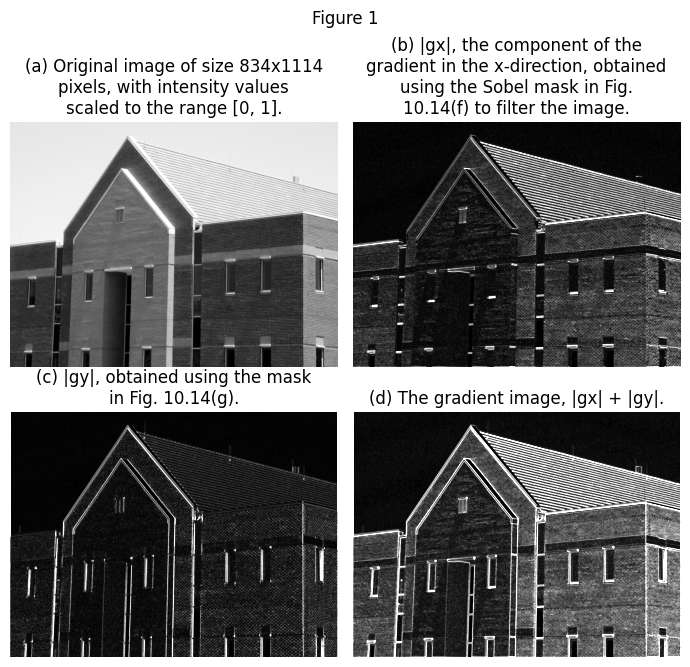

In [5]:
fig, ax = plt.subplots(2, 2, figsize=(7, 7))
ax[0, 0].axis("off"), ax[0, 1].axis("off"), ax[1, 0].axis("off"), ax[1, 1].axis("off")
ax[0, 0].imshow(data, cmap="gray", vmin=0, vmax=255), ax[0, 1].imshow(f_xsobel, cmap="gray", vmin=0, vmax=255)
ax[1, 0].imshow(f_ysobel, cmap="gray", vmin=0, vmax=255), ax[1, 1].imshow(f_sobelGradient, cmap="gray", vmin=0, vmax=255)
ax[0, 0].set_title("(a) Original image of size 834x1114\npixels, with intensity values\nscaled to the range [0, 1].")
ax[0, 1].set_title("(b) |gx|, the component of the\ngradient in the x-direction, obtained\nusing the Sobel mask in Fig.\n10.14(f) to filter the image.")
ax[1, 0].set_title("(c) |gy|, obtained using the mask\nin Fig. 10.14(g)."), ax[1, 1].set_title("(d) The gradient image, |gx| + |gy|.")
fig.suptitle("Figure 1")
fig.tight_layout()
plt.show()

Figure1(b) şıkkındaki görüntü orijinal görüntünün x yönünde sobel filtre maskesi ile korelasyonu sonucunda ortaya çıkmıştır. Ortaya çıkan görüntü incelendiğinde, x(aşağı) yönde kenar tespiti yapıldığı fark edilmiştir. Fakat görüntüde çatıdaki kiremitlerde de kenar tespiti yapıldığı gözlemlenmiştir. Benzer şekilde, Figure1(c)'de orijinal görüntüye y yönünde sobel filtresi uygulanmış ve bu sefer yataydaki kenarlar tespit edilmiştir. Fakat yatay olarak yerleştirilen kiremitler, yatayda kenar tespiti yapıldığından bu sefer belirgin bir şekilde gözlemlenmemiştir. (d) şıkkındaki görselde bu iki yönde yapılan sobel filtrelerinin mutlaklarının toplamı olan Sobel Gradient filtresi gözlemlenmiştir. Figure1(d)'de gözlemlenen filtre her ne kadar kenar tespitinde başarılı olsa da bölgesel bir kenar tespiti veya segmentasyon yapmaya uygun değildir.

### SORU-2

In [6]:
f_smoothedImage = myImageCorrelation(np.ones((5,5)), data, 1, 0)
f_xsobel_smoothedImage = np.abs(myImageCorrelation(xsobel_kernel3x3, f_smoothedImage, 0, 0))
f_ysobel_smoothedImage = np.abs(myImageCorrelation(ysobel_kernel3x3, f_smoothedImage, 0, 0))
f_sobelGradient_smoothedImage = myImageSobelGradient(xsobel_kernel3x3, f_smoothedImage)

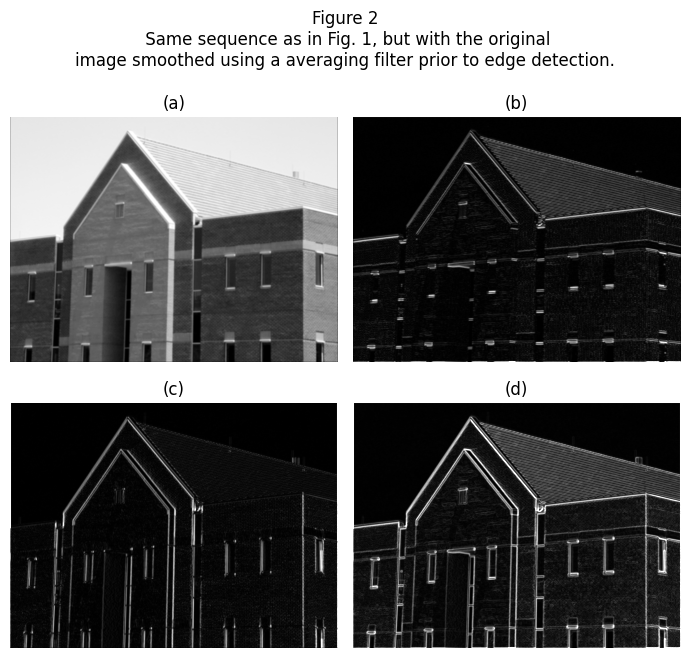

In [7]:
fig, ax = plt.subplots(2, 2, figsize=(7, 7))
ax[0, 0].axis("off"), ax[0, 1].axis("off"), ax[1, 0].axis("off"), ax[1, 1].axis("off")
ax[0, 0].imshow(f_smoothedImage, cmap="gray", vmin=0, vmax=255), ax[0, 1].imshow(f_xsobel_smoothedImage, cmap="gray", vmin=0, vmax=255)
ax[1, 0].imshow(f_ysobel_smoothedImage, cmap="gray", vmin=0, vmax=255), ax[1, 1].imshow(f_sobelGradient_smoothedImage, cmap="gray", vmin=0, vmax=255)
ax[0, 0].set_title("(a)"), ax[0, 1].set_title("(b)")
ax[1, 0].set_title("(c)"), ax[1, 1].set_title("(d)")
fig.suptitle("Figure 2\n Same sequence as in Fig. 1, but with the original\nimage smoothed using a averaging filter prior to edge detection.")
fig.tight_layout()
plt.show()

Figure2(a)'daki görüntü orijinal görüntüye 5x5'lik ortalama maskesinin uygulanması sonucunda ortaya çıkmıştır. Figure2(b), (c) ve (d) şıklarında Figure2(a)'daki bulanıklaştırılmış görüntüye Figure1'dekiler ile benzer işlemler uygulanmıştır. Bunun sonucunda Figure2(b)'deki görsel Figure1'dekine kıyasla görseldeki parazitlerin kenar tespitinde yer almadığı ve sadece dominant bölgelerin kenar tespitinde ortaya çıktığı görülmüştür. Ayrıca, kiremit olan bölge de daha zayıf bir şekilde kenarları tespit edilmiş ve çatı bölgesinin algılanması kolaylaşmıştır. Benzer şekilde, Figure2(c) ve (d) şıklarında da parazit bölgeler çıkartılmış ve asıl tespit edilmesi gereken bölgesel yerlerin kenarları tespit edilmiştir. Böylece, Figure2'de yapılan yumuşatma işlemi sonrasında yapılan Sobel filtrelerinin, Figure1'deki kenar tespitine kıyasla daha iyi sonuç verdiği gözlemlenmiştir.

### SORU-3

In [8]:
magicnum, width, height, maxval, data = mypgmread("Fig1038(a).pgm")

b'P5'
798 958
255
205 205 201 201 204 204 196 196 188 188 184 184 194 194 203 203 200 200 198 198 192 192 180 180 179 179 189 189 201 201 202 202 190 190 183 183 199 199 204 204 186 186 188 188 202 202 191 191 186 186 180 180 189 189 199 199 191 191 194 194 191 191 183 183 179 179 198 198 202 202 204 204 198 198 183 183 191 191 194 194 203 203 191 191 186 186 198 198 202 202 182 182 184 184 202 202 201 201 195 195 195 195 188 188 190 190 187 187 196 196 195 195 198 198 202 202 194 194 197 197 197 197 194 194 193 193 176 176 179 179 181 181 184 184 199 199 188 188 192 192 195 195 203 203 196 196 185 185 183 183 192 192 194 194 192 192 193 193 186 186 178 178 188 188 190 190 192 192 188 188 191 191 196 196 195 195 192 192 182 182 187 187 197 197 189 189 189 189 194 194 196 196 195 195 202 202 205 205 196 196 197 197 200 200 181 181 190 190 193 193 194 194 200 200 202 202 200 200 196 196 190 190 196 196 197 197 190 190 195 195 187 187 169 169 81 81 50 50 75 75 104 104 181 181 212 212 191 

In [9]:
"""
@brief Applies basic global thresholding to the given image data.
@param1 data: 2D array containing the image pixel data.
@param2 L: Maximum pixel value.
@retval thresholding_data: 2D array containing the image pixel data applied basic global threshold.
"""
def my_basic_global_thresholding(data, L=256):
    data = np.array(data)
    T = np.sum(data)/data.size
    def get_opt_threshold(data, T):
        T_prv = 0
        T_new = T
        while np.abs(T_new-T_prv)>1:
            G1 = np.where(data<=T_new)
            G2 = np.where(data>T_new)
            m1 = np.sum(data[G1])/len(G1[0])
            m2 = np.sum(data[G2])/len(G2[0])
            T_prv = T_new
            T_new = (m1+m2)/2
        return T_new
    threshold = get_opt_threshold(data, T)
    thresholding_data = np.where(data > threshold, L-1, 0)
    print(f'optimum threshold To: {threshold}')
    return thresholding_data

In [10]:
L = 256
data = np.array(data)
histogram, bins = np.histogram(data, bins=L, range=(0, L))
normalized_histogram = histogram / data.size
thresholding_data = my_basic_global_thresholding(data, L-1)

optimum threshold To: 125.38601930911415


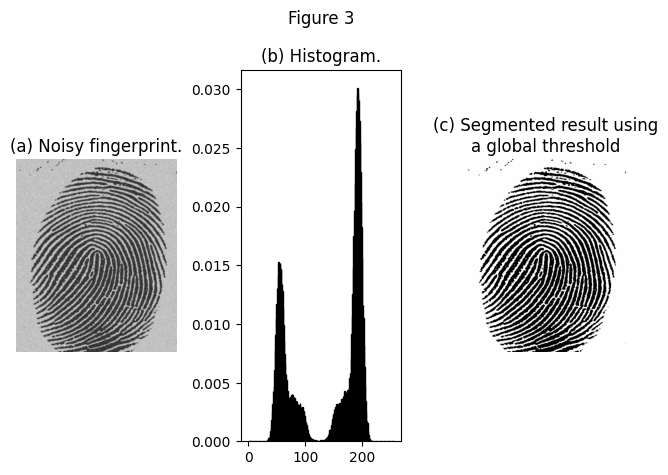

In [11]:
fig, ax = plt.subplots(1, 3)
ax[0].axis("off"), ax[2].axis("off")
ax[0].imshow(data, cmap="gray", vmin=0, vmax=255), 
ax[1].bar(bins[:-1], normalized_histogram, edgecolor='black')
ax[2].imshow(thresholding_data, cmap="gray", vmin=0, vmax=255)
ax[0].set_title("(a) Noisy fingerprint."), ax[1].set_title("(b) Histogram."), ax[2].set_title("(c) Segmented result using\na global threshold")
fig.suptitle("Figure 3")
fig.tight_layout()
plt.show()

Figure3(a) şıkkındaki görselin normalize histogramı Figure3(b) şıkkında gösterilmiştir. Figure3(c) şıkkında eşikleme uygulanan görsel için optimum eşik değeri bulunarak tüm görsele aynı eşik uygulanmıştır. Bunun için öncelikle görüntüdeki pixel değerleri toplanıp pixel sayısına bölünerek ortalama threshold Tm değeri başlangıçta verilmiştir. Sonrasında, Bu değer fonksiyon içerisine sokularak bir kaç iterasyon sonucunda bir önceki ve bir sonraki threshold farkının 1 değerinden büyük olacağı noktaya kadar devam etmesi ile en sonunda optimum threshold değeri To bulunmuştur. Bu fonksiyon içerisinde bu işlemi yapmak için histogramda threshold değerine göre sağında ve solunda kalan G1 ve G2 guruplarının ortalama pixel değerleri m1 ve m2 şeklinde bulunmuş ve bulunan ortalama pixel değerlerinin ortalaması To olarak alınarak önceki iterasyondaki To değeri ile karşılaştırma işlemine devam edilmiştir. Bu işlemler sonucunda Figure3(c)'de bulunan eşikleme görselinin (a) şıkkına göre daha net olduğu gözlemlenmiştir.

### SORU-4

In [12]:
magicnum, width, height, maxval, data = mypgmread("Fig1050(a).pgm")

b'P5'
772 686
255
0 0 0 136 130 124 119 113 108 103 0 0 0 0 80 76 72 69 66 63 60 58 56 54 0 0 0 51 51 51 52 53 54 56 0 0 0 0 0 0 0 79 84 88 93 97 102 107 113 118 124 129 135 141 146 152 158 164 170 175 181 186 192 197 202 207 212 217 221 225 229 233 237 240 243 245 248 0 0 253 254 255 255 255 0 0 0 252 250 249 246 244 241 238 235 231 227 223 219 214 209 204 199 194 189 183 178 172 166 160 155 149 143 137 132 126 120 115 110 104 99 95 90 85 81 77 73 70 67 64 61 59 57 55 53 52 52 51 51 51 52 53 54 55 57 59 62 65 68 71 74 78 82 87 91 96 101 106 111 116 122 128 133 139 145 151 156 162 168 174 179 185 190 196 201 206 211 215 220 224 228 232 236 239 242 245 247 249 251 252 254 254 255 255 255 254 254 252 251 249 247 245 242 239 236 232 228 224 0 215 211 206 201 196 190 185 0 174 168 162 156 151 145 139 133 128 122 116 111 106 101 96 91 87 82 78 74 71 68 65 62 59 57 55 54 53 52 51 51 51 52 52 53 55 57 59 61 64 67 70 73 77 81 85 90 95 99 104 110 115 120 126 132 137 143 149 155 160 166 172 178 

In [13]:
"""
@brief  Applies Otsu's thresholding method to the image data.
@param1 data: 2D array containing the image pixel data.
@param2 L: maximum pixel value (default is 256).
@retval thresholded_image: The binary image after applying Otsu's thresholding.
"""
def my_otsu_thresholding(data, L=256):
    histogram, _ = np.histogram(data.flatten(), bins=L, range=(0, L))
    normalized_histogram = histogram / np.sum(histogram)
    L = len(normalized_histogram)

    max_variance_b = 0
    optimal_threshold = 0

    for k in range(L):
        P1 = np.cumsum(normalized_histogram[:k+1])
        P2 = 1 - P1[k]
        if P1[k] == 0 or P2 == 0:
            continue
        m1 = np.sum([i * normalized_histogram[i] for i in range(k+1)]) / P1[k]
        m2 = np.sum([i * normalized_histogram[i] for i in range(k+1, L)]) / P2

        variance1 = np.sum([((i - m1) ** 2) * normalized_histogram[i] for i in range(k+1)]) / P1[k]
        variance2 = np.sum([((i - m2) ** 2) * normalized_histogram[i] for i in range(k+1, L)]) / P2

        q1, q2 = P1[k], P2
        variance_w = q1 * variance1 + q2 * variance2
        mean = np.sum([i * normalized_histogram[i] for i in range(L)])
        variance = np.sum([((i - mean) ** 2) * normalized_histogram[i] for i in range(L)])
        variance_b = variance - variance_w

        if variance_b > max_variance_b:
            max_variance_b = variance_b
            optimal_threshold = k

    print(optimal_threshold)

    return np.where(data > optimal_threshold, L-1, 0)

"""
@brief  Applies a moving averages local thresholding method to the image data.
@param1 data: 2D array containing the image pixel data.
@param2 n: Size of the moving window.
@param3 b: Bias factor for thresholding.
@retval output_image: The binary image after applying local thresholding.
"""
def my_moving_averages_local_thresholding(data, n, b):
    height, width = data.shape
    size = width * height

    Z = np.zeros(size + n, dtype=np.uint8)
    T = np.zeros(size, dtype=np.float32)
    T_inverse = np.zeros(size, dtype=np.int32)

    index = n
    for i in range(height):
        if i % 2 == 0:
            Z[index:index + width] = data[i, :]
        else:
            Z[index:index + width] = data[i, ::-1]
        index += width

    for i in range(size):
        T[i] = np.mean(Z[i:i + n]) * b

    index = 0
    for i in range(height):
        if i % 2 == 0:
            T_inverse[index:index + width] = T[i * width:(i + 1) * width]
        else:
            T_inverse[index:index + width] = T[i * width:(i + 1) * width][::-1]
        index += width

    output_data = np.where(data.flatten() > T_inverse, 255, 0).astype(np.uint8)
    output_image = output_data.reshape((height, width))

    return output_image

In [14]:
data = np.array(data)
thresholding_data = my_basic_global_thresholding(data, 256)
otsu_thresholding_data = my_otsu_thresholding(data)
moving_averages_local_thresholding_data = my_moving_averages_local_thresholding(data, 20, 0.5)

optimum threshold To: 136.15646922985246
136


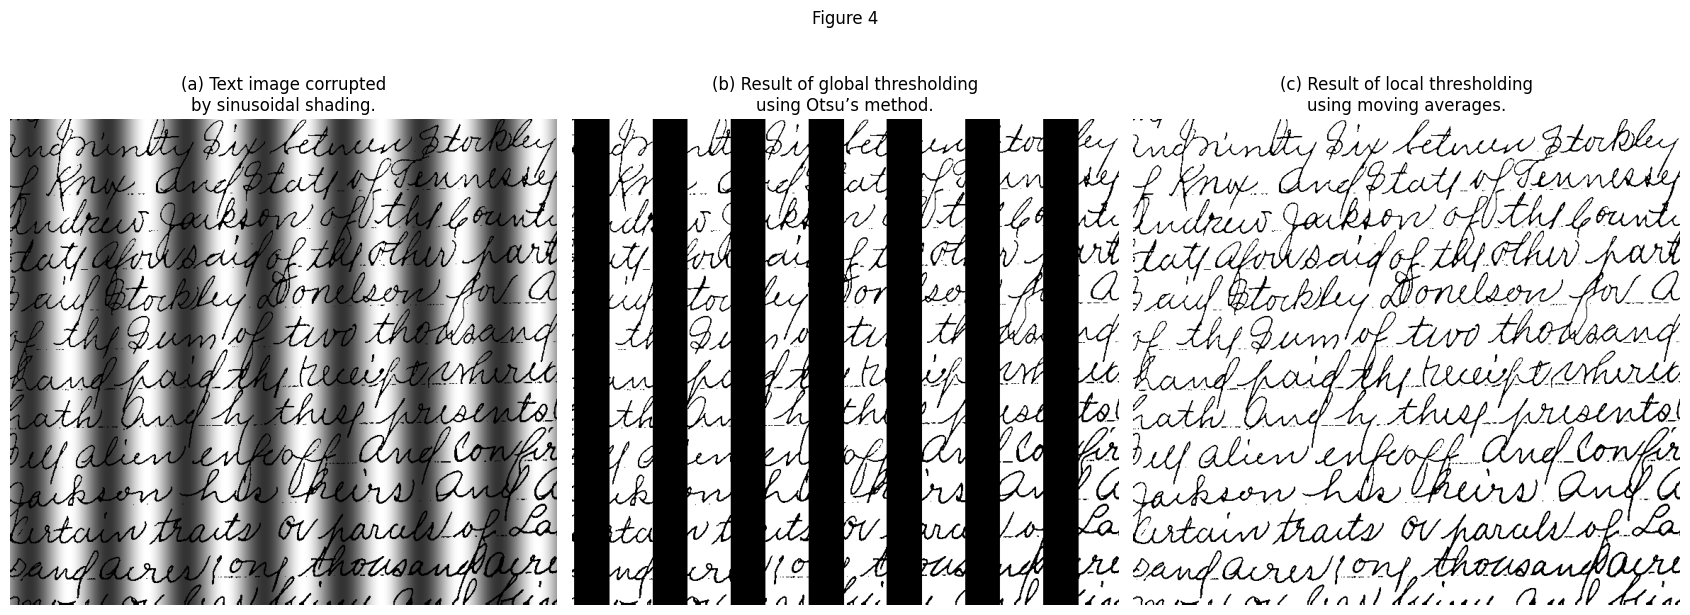

In [15]:
fig, ax = plt.subplots(1, 3, figsize=(17, 7))
ax[0].axis("off"), ax[1].axis("off"), ax[2].axis("off")
ax[0].imshow(data, cmap="gray", vmin=0, vmax=255), ax[1].imshow(otsu_thresholding_data, cmap="gray", vmin=0, vmax=255)
ax[2].imshow(moving_averages_local_thresholding_data, cmap="gray", vmin=0, vmax=255)
ax[0].set_title("(a) Text image corrupted\nby sinusoidal shading."), ax[1].set_title("(b) Result of global thresholding\nusing Otsu’s method.")
ax[2].set_title("(c) Result of local thresholding\nusing moving averages.")
fig.suptitle("Figure 4")
fig.tight_layout()
plt.show()

Figure4(a)'daki görsele bakıldığında sinüzoidal bir dalgalanma gözlemlenmektedir. Bu görsele Otsu threshold methodu uygulanması sonucunda ortaya çıkan görsel Figure4(b) şıkkında gösterilmektedir. Burada, orijinal görüntüdeki dalgalanmalar sonucunda dikey eksenlerde kararmaların uygulanacak global bir thresholding değerinde eşiğin altında kalması sonucu siyahlaşacağı gözlemlenmiştir. Burada, herhangi bir global thresholding metodunun benzer sonucu vereceği ve yazıyı tam olarak tespit edemeyeceği anlaşılmıştır. Bu nedenle, Otsu Thresholding metodunun bu görsel için uygun olmadığı belirlenmiştir. Bunun yerine, Figure4(c)'deki gibi ortalama filtresi kullanılarak local thresholding metodu yapmanın daha iyi bir sonuç verdiği gözlemlenmiştir. seçilen n ve b değerlerine göre belirli bir bölgenin pixellerinin ortalaması alınarak o bölgeye özgü threshold değeri belirlenmesi ve o bölgedeki yazıların tespit edilmesi sağlanmıştır. Bunun sonucunda yazının daha net anlaşıldığı görülmüştür.